# Isolation by spatial random walks

Here I explore the isolation by resistence [[McRae 2006](https://github.com/jhmarcus/spatial-random-walk/tree/master/ref/mcrae_2006.pdf); [McRae 2007](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/mcrae_beier_2007.pdf)] approximation to expected genetic distances using simulations under the coalescent, following [[Petkova et al. 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/petkova_et_al_2016.pdf)]. I also explore a recent development in the spatial statistics literature, which derives the induced covariance under a spatial-temporal random walk that can be implemented as a simulatanous auto-regressive process (SAR) [[Hanks 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/hanks_2016.pdf)]. This framework allows for an analgous concept of resistence distance on directed graphs which could be of use for inference of asymetric migration in natural systems. See the `../ref` directory for a non-exhausitve list of other relevent papers on this topic.

# Background

## A simultanous autogressive model for genotype data

Here we follow [[Hanks 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/hanks_2016.pdf)] but switch up the notation a bit and gloss over most of the derivations. We also focus on large scale genotype data rather than using a SAR process as a random effect for microsatellite data. First, consider a single SNP $j$ with $\mathbf{y}_j$ carrying the mean centered genotypes of $n$ individuals. We define a dense regular lattice or graph $\mathcal{G}$ over geographic space. For simplicity, lets imagine we sample a single individual from every node on the graph. Let $\mathbf{M}$ be a $n \times n$ matrix storing the edge weights of $\mathcal{G}$. Note that because $\mathcal{G}$ is directed $\mathbf{M}$ is not necessarily symmetric. The exact structure of this lattice will determine what nodes are connected to each other and the magnitude of $m_{ij}$ is reflective of some migration process. In general $\mathbf{M}$  will be very sparse as nodes will only be connected to their neighbors. We define the typical SAR model for the observed genotypes ...


$$
\mathbf{y}_j = \rho\mathbf{W}\mathbf{y}_j + \mathbf{\nu} \\
$$

where $\mathbf{W}$ is the spatial weights matrix which is related to $\mathbf{M}$, $\rho$ is the autoregressive parameter and $\nu$ is a random effect with $\nu | \mathbf{\Lambda} \sim \mathcal{N}(\nu|\mathbf{0}, \mathbf{\Lambda})$ where $\mathbf{\Lambda}$ is a $n \times n$ diagonal matrix. We can simplify the above equation ...

$$
\mathbf{y}_j - \rho\mathbf{W}\mathbf{y}_j  = \mathbf{\nu} \\
(\mathbf{I} - \rho\mathbf{W})\mathbf{y}_j = \mathbf{\nu} 
$$

Thus as long as $(\mathbf{I} - \rho\mathbf{W})^{-1}$ ...

$$
\mathbf{y}_j = (\mathbf{I} - \rho\mathbf{W})^{-1}\mathbf{\nu }
$$

then ...

$$
\mathbf{y}_j | \mathbf{W}, \mathbf{\Lambda} \sim \mathcal{N}\Big(\mathbf{y}_j | \mathbf{0}, \big((\mathbf{I} - \rho\mathbf{W})\mathbf{\Lambda}(\mathbf{I} - \rho\mathbf{W}^T)\big)^{-1} \big)
$$

If we let $\mathbf{B} = \rho\mathbf{W}$ and set ...

$$
b_{ij} = \frac{m_{ji}}{\sum_{k} m_{ik}} \\
\lambda_{ii} = \frac{1}{(\sum_{k} m_{ik})^2}
$$

then ...

$$
\mathbf{L}\mathbf{L}^T = (\mathbf{I} - \mathbf{B})\mathbf{\Lambda}(\mathbf{I} - \mathbf{B}^T)
$$

where $\mathbf{L}$ is the graph laplacian of $\mathcal{G}$. This implies that

$$
\mathbf{y}_j \sim \mathcal{N}\big(\mathbf{y}_j | \mathbf{0}, (\mathbf{L}\mathbf{L}^T)^{-1}\big)
$$

# Simulations

## Imports / Configuration

Import standand libraries as well as some scripts in `../scripts` that have defined helper function to setup the habitat and simulate data under the coalescent given a habitat

In [4]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

sns.set_style('whitegrid')

mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import laplacian
from scipy.linalg import pinv
import pickle as pkl
import os

# import helper functions for this notebook
import sys
sys.path.append('../scripts/')
from define_habitat import gen_lattice, quadratic_barrier_weights
from simulate_genotypes import stepping_stone

## Setup the habitat

Here we simulate a habitat as a $8 \times 8$ triangular lattice $\mathcal{G}$ consiting of nodes and edges $\{\mathbf{v}, \mathbf{e}\}$. To simulate a barrier we define a quadratic function $f(s)$ of the spatial positions $s$ of each node. $f(s)$ is minimized at the middle of the barrier and the barrier is always set in the center of the habitat. We will consider different migration patterns later.

In [5]:
n = 8
p = 8
d = n * p
lattice_dict = gen_lattice(n, p)
g = lattice_dict['g']
s = lattice_dict['s']
v = lattice_dict['v']
pos_dict = lattice_dict['pos_dict']
m_min = .01 # max migration level
m_max = 3. # min migration level
g = quadratic_barrier_weights(g, s, m_min, m_max)
weights = [g[i][j]['m'] for i,j in g.edges()]

The triangular lattice is visualized with edge widths proportional to the defined edge weights, note we multiply by some constant just for visualization purposes. 

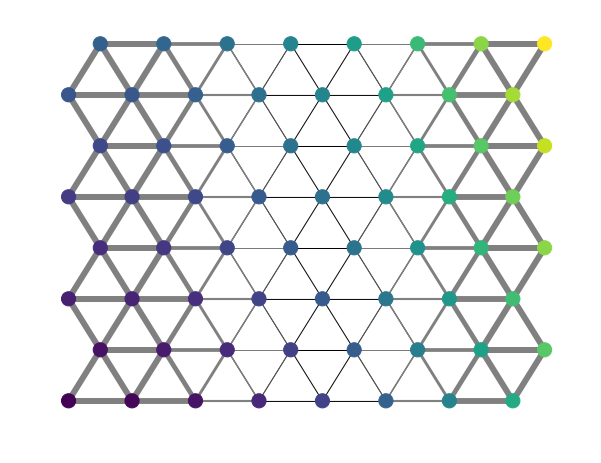

In [34]:
nx.draw(g, pos=pos_dict, node_size=200, node_color=s[:,0]**2 + (np.sqrt(d) / 2) * s[:,1], cmap=cm.viridis)  
nx.draw_networkx_edges(g, pos_dict, width=2*np.array(weights), edge_color='gray')

Extract the migration matrix $\mathbf{M}$ which stores all the edge weights in $\mathcal{H}$

In [7]:
m = nx.adjacency_matrix(g, weight='m')
m = m.toarray()
d = m.shape[0]

As expected we see that the migration matrix $\mathbf{M}$ is extremley sparse as only neighboring nodes are connected

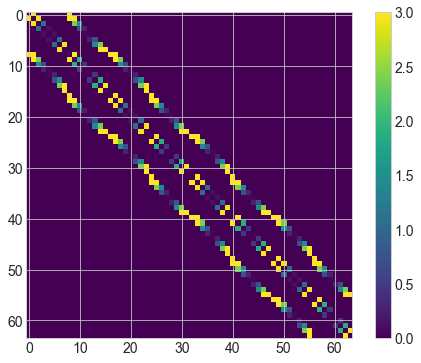

In [8]:
plt.imshow(m, cmap=cm.viridis)
plt.colorbar()

## Simulate genotypes

Here we simulate genotypes under the coalescent using `msprime` ... this may take a bit of time. Specifically we simulate 10 haploid individuals per node in 5000 indepedent regions of the genome. See `../scripts/simulate_genotypes` for default parameters

In [9]:
%%time
path = '../output/y_barrier_stepping_stone.pkl'
if os.path.exists(path):
    with open(path, 'rb') as geno:
        y = pkl.load(geno)
else:
    with open(path, 'wb') as geno:
        y = stepping_stone(m, n_rep=5000, n=10)
        pkl.dump(y, geno)

extracting tree 0
extracting tree 250
extracting tree 500
extracting tree 750
extracting tree 1000
extracting tree 1250
extracting tree 1500
extracting tree 1750
extracting tree 2000
extracting tree 2250
extracting tree 2500
extracting tree 2750
extracting tree 3000
extracting tree 3250
extracting tree 3500
extracting tree 3750
extracting tree 4000
extracting tree 4250
extracting tree 4500
extracting tree 4750
CPU times: user 20min 26s, sys: 7.27 s, total: 20min 33s
Wall time: 20min 52s


In [10]:
n, p = y.shape 
print(n, p)

640 10522


Extract individual positions, demes, and migration rates

In [11]:
v_obs = np.repeat(v, int(n / d)).T
s_obs = np.vstack([np.repeat(s[:,0], int(n / d)), np.repeat(s[:,1], int(n / d))]).T
m_obs = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        m_obs[i,j] = m[v_obs[i], v_obs[j]]

Here we visualize the site frequency spectrum and can see an enricment of common variants under the netural constant population size / random mating expectation which is expected given the migration model we have defined!

Text(0,0.5,'log(Count)')

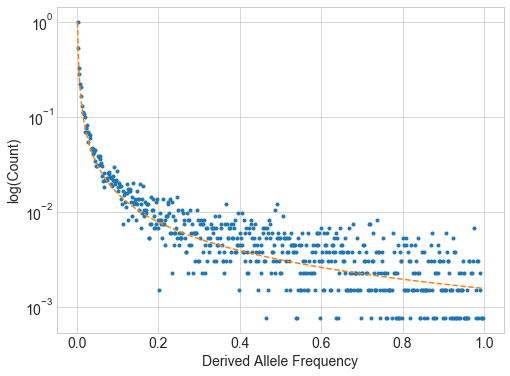

In [12]:
dac = np.sum(y, axis=0) 
x = np.arange(1, n) / n
sfs = np.histogram(dac, bins=np.arange(1, n+1))[0]
plt.semilogy(x, sfs / sfs[0], '.')
plt.semilogy(x, 1 / (x * n), '--')
plt.xlabel('Derived Allele Frequency')
plt.ylabel('log(Count)')

Lets remove rare variants for subsequent visualization

In [13]:
fil_idx = np.where(((dac / n) >= .05) & ((dac / n) <= .95))[0]
y = y[:,fil_idx]
p = float(y.shape[1])
print(n, p)

640 4738.0


Normalize the data for PCA

In [15]:
mu = np.mean(y, axis=0)
std = np.std(y, axis=0)
z = (y - mu) / std

Running PCA on the normalized genotype data, we see a strong signature of the barrier.

Text(0,0.5,'PC2')

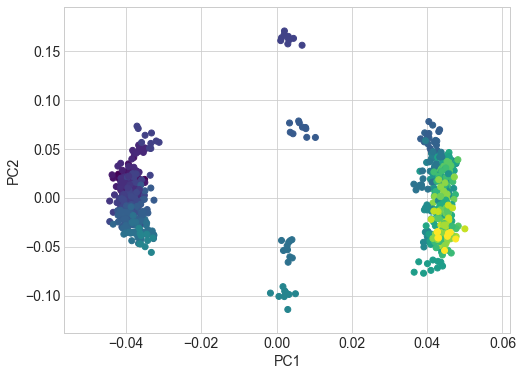

In [16]:
pca = PCA(n_components=5)
pca.fit(z.T)
pcs = pca.components_.T
plt.scatter(pcs[:,0], pcs[:,1], c=s_obs[:,0]**2 + (np.sqrt(d) / 2) * s_obs[:,1], cmap=cm.viridis)
plt.xlabel('PC1')
plt.ylabel('PC2')

## Computing distances

Compute the squred euclidian genetic distance using the mean centered genotypes

In [17]:
d_geno = squareform(pdist((y - mu), metric='seuclidean')) / p

We compute the resistence distance using the inverse of the graph laplacian ...


$$
\mathbf{L} = \mathbf{D} - \mathbf{M}
$$

$$
\mathbf{R} = \mathbf{1}diag(\mathbf{L}^{-1})^T + diag(\mathbf{L}^{-1})\mathbf{1}^T - 2\mathbf{L}^{-1}
$$

where $\mathbf{D}$ is a diagonal matrix storing the degree $d_{ii} = \sum_{k \neq i} d_{ik}$ of each node and $\mathbf{1}$ is a column vector of size $n$. The matrix form above correponds to ...

$$
r_{ij} = l^{-1}_{ii} + l^{-1}_{jj} - 2l^{-1}_{ij}
$$

Additionaly we compute the random-walk distance, following [[Hooten 2016]()] by ...

$$
\tilde{\mathbf{R}} = \mathbf{1}diag\big((\mathbf{L}\mathbf{L}^T)^{-1}\big)^T + diag\big((\mathbf{L}\mathbf{L}^T)^{-1}\big)\mathbf{1}^T - 2(\mathbf{L}\mathbf{L}^T)^{-1}
$$

Compute the geographic distance based on the lattice $\mathcal{G}$ positions

In [18]:
d_geo = squareform(pdist(s_obs, metric='seuclidean')) / 2

Compute the graph laplacian

In [19]:
l = laplacian(m_obs)
print(l.shape)

ones = np.ones(n).reshape(n, 1)
print(ones.shape)

(640, 640)
(640, 1)


We can see the graph laplacian is sparse as $\mathbf{M}$ is sparse. We can think of $\mathbf{L}$ here as a sparse presicion matrix.

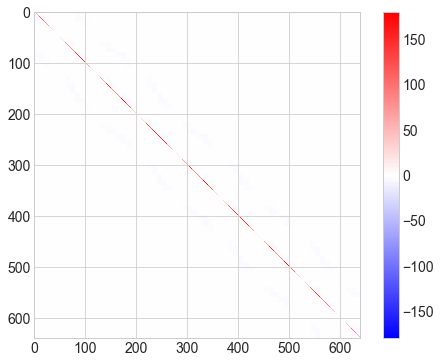

In [20]:
plt.imshow(l, cmap='bwr', norm=mpl.colors.Normalize(vmin=-np.max(l), vmax=np.max(l)))
plt.colorbar()

Compute the resistence distance $\mathbf{R}$

In [21]:
linv = pinv(l)
linv_diag = np.diag(linv).reshape(n, 1)
d_res = ones.dot(linv_diag.T) + linv_diag.dot(ones.T) - (2. * linv)

Compute the random-walk distance $\tilde{\mathbf{R}}$

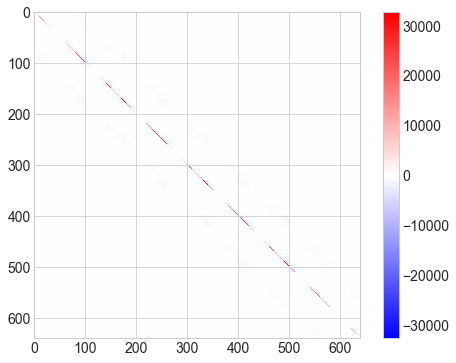

In [22]:
llt = l.dot(l.T)
plt.imshow(llt, cmap='bwr', norm=mpl.colors.Normalize(vmin=-np.max(llt), vmax=np.max(llt)))
plt.colorbar()

In [23]:
lltinv = pinv(llt)
lltinv_diag = np.diag(lltinv).reshape(n, 1)
d_rw = ones.dot(lltinv_diag.T) + lltinv_diag.dot(ones.T) - (2. * lltinv)

Visualize the semivarigram for difference input distances

In [24]:
tri_idx = np.tril_indices(n, -1)
dist_df = pd.DataFrame({'Geographic Distance': d_geo[tri_idx], 
                        'Genetic Distance': d_geno[tri_idx],
                        'Resistence Distance': d_res[tri_idx],
                        'Random-Walk Distance': d_rw[tri_idx]
                       })


r2 = 0.5674728750750556


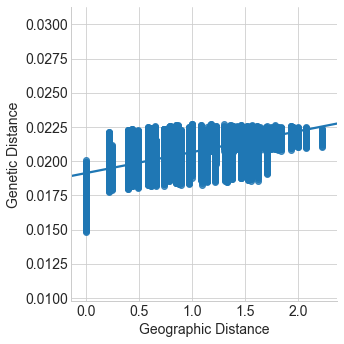

In [25]:
print('r2 = {}'.format(np.corrcoef(dist_df['Geographic Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Geographic Distance', y='Genetic Distance', data=dist_df)

r2 = 0.09942934156350462


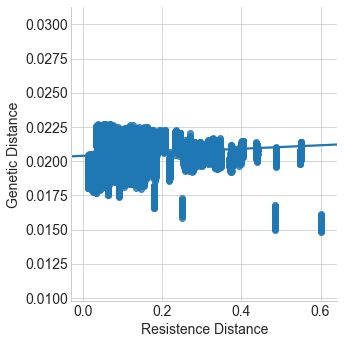

In [26]:
print('r2 = {}'.format(np.corrcoef(dist_df['Resistence Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Resistence Distance', y='Genetic Distance', data=dist_df)

r2 = 0.7120488719841309


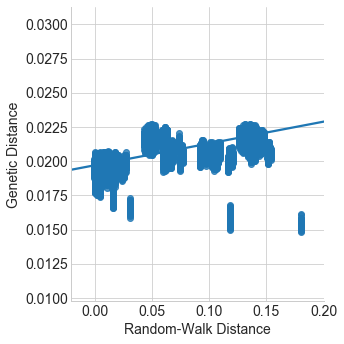

In [27]:
print('r2 = {}'.format(np.corrcoef(dist_df['Random-Walk Distance'], dist_df['Genetic Distance'])[0, 1]))
sns.lmplot(x='Random-Walk Distance', y='Genetic Distance', data=dist_df)


We can see that the random-walk distance has the highest correlation with the genetic distance out of the 3 we compare here. I'm confused why the resistence distance is performing so poorly here as it should be better than geographic distance ... perhaps its some bug in the code.